[[32  7  1  0  0  0]
 [ 1 36  5  0  0  0]
 [ 0  2 23  4  0  0]
 [ 0  0  0 15  5  0]
 [ 0  0  0  0 15  1]
 [ 0  0  0  0  0  0]]


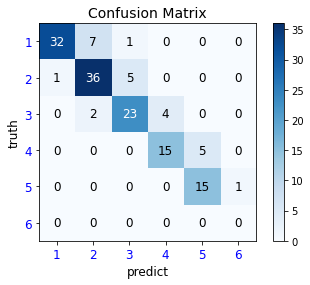

In [9]:
import numpy as np
import os #此文件放于经map.ipynb生成的map_out文件夹内，结合ground-truth和detection-result生成混淆矩阵并绘制
import matplotlib.pyplot as plt
def file_lines_to_list(path):
    with open(path) as f: content = f.readlines()
    return [x.strip().split() for x in content]
def iou(box1, box2, eps=1e-7): # x1, y1, x2, y2 = box1
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[-4:]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[-4:]
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
    inter = max((min(b1_x2,b2_x2) - max(b1_x1,b2_x1)),0) * \
            max((min(b1_y2,b2_y2) - max(b1_y1,b2_y1)),0)
    return inter / (w1 * h1 + w2 * h2 - inter + eps)

def calculate_confusion_matrix(predict_folder, label_folder, nc, iou_thres=0.8):
    cm = np.zeros((nc, nc), dtype=int)# 初始化混淆矩阵
    for filename in os.listdir(label_folder):# 遍历文件夹
        if filename.split(".")[1]!="txt":break# 可能出现节点文件
        predict_file = os.path.join(predict_folder, filename)
        label_file = os.path.join(label_folder, filename)
        predictions = file_lines_to_list(predict_file)
        labels = file_lines_to_list(label_file)
        matched_preds,matched_labels = set(),set()
        for i, pred in enumerate(predictions):
            for j, label in enumerate(labels):
                pred = np.array([float(x) for x in pred])
                label = np.array([float(x) for x in label])
                if iou(pred, label) >= iou_thres:
                    if i not in matched_preds and j not in matched_labels:
                        cm[int(pred[0])][int(label[0])] += 1
                        matched_preds.add(i)
                        matched_labels.add(j)
                        break
#         for i, pred in enumerate(predictions):
#             if i not in matched_preds:#对于未匹的预测和标签，记为背景类
#                 cm[int(pred[0])][-1] += 1  # 最后一列为背景类别
#         for j, label in enumerate(labels):
#             if j not in matched_labels:
#                 cm[-1][int(label[0])] += 1  # 最后一行为背景类别
    return cm
confusion_matrix=calculate_confusion_matrix("detection-results","ground-truth",6)
confusion_matrix=np.array([[32,7,1,0,0,0],[1,36,5,0,0,0],[0,2,23,4,0,0],[0,0,0,15,5,0],[0,0,0,0,15,1],[0,0,0,0,0,0]])#改进前
# confusion_matrix=np.array([[33,4,0,0,0,0],[0,41,1,0,0,0],[0,0,28,1,0,0],[0,0,0,18,2,0],[0,0,0,0,17,0],[0,0,0,0,0,1]])#改进后
print(confusion_matrix)#上面一个加入类别损失前后的混淆矩阵，若后无更进一步细化则可以之作例

def draw_confusion_matrix(cm, label_name, title, pdf_save_path="CM.png", dpi=600): #保存到文件的分辨率，论文一般要求至少300dpi
    plt.imshow(cm, cmap='Blues');plt.xlabel("predict",size=12)  #cmap还可设为比较好看的 viridis winter
    plt.ylabel("truth",size=12);plt.title(title,size=14)#图标题
    plt.yticks(range(label_name.__len__()), label_name,size=12, rotation=0,color ="blue")#标签名字，如['cat','dog',..],figsize=[200,400]
    plt.xticks(range(label_name.__len__()),label_name,size=12,color="blue")#black
    plt.colorbar(); thresh = confusion_matrix.max() / 2. 
    for i in range(label_name.__len__()):
        for j in range(label_name.__len__()):
            color="white" if confusion_matrix[i, j] > thresh else "black"  # 对角线字体白色，其他黑色
            plt.text(i,j,cm[j,i],size=12,verticalalignment='center',horizontalalignment='center',color=color)
    if not pdf_save_path is None:plt.savefig(pdf_save_path, bbox_inches='tight',dpi=dpi, facecolor="w")
ax1 = plt.subplot()
# ax1.spines['left'].set_visible(False)	#左边框线隐藏,下边则bottom..
# ax1.xaxis.set_tick_params(left=False)#左边刻度线隐藏
draw_confusion_matrix(confusion_matrix,[1,2,3,4,5,6],title="Confusion Matrix")